**Makemore v3**

-   Kaiming Init for weights
-   Batch Normalization
-   Backprop with torch


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from math import sqrt

%matplotlib inline

In [2]:
# read in all the words
words = open("../makemore/names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset

block_size = 3  # How many characters do we take to predict the next one?


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"{X.shape=}\t {Y.shape=}")
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

X.shape=torch.Size([182625, 3])	 Y.shape=torch.Size([182625])
X.shape=torch.Size([22655, 3])	 Y.shape=torch.Size([22655])
X.shape=torch.Size([22866, 3])	 Y.shape=torch.Size([22866])


In [6]:
# MLP revisited
n_embed = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
kaiming = (5 / 3) / sqrt(n_embed * block_size)

C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * kaiming
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# Batch Normalization
bngain = torch.ones((1, n_hidden))  # Normalised during first iteration & then learned.
bnbias = torch.zeros((1, n_hidden))  # Init to 0 such that initial shift is skipped.
bnmean = torch.zeros((1, n_hidden))  # Mean over the whole training set
bnstd = torch.ones((1, n_hidden))  # Std over the whole training set

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
losses = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1  # hidden layer pre-activation
    bnmean_i = hpreact.mean(0, keepdim=True)
    bnstd_i = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmean_i) / bnstd_i + bnbias

    with torch.no_grad():
        bnmean = 0.999 * bnmean + 0.001 * bnmean_i
        bnstd = 0.999 * bnstd + 0.001 * bnstd_i

    h = torch.tanh(hpreact)  # Non-linearity
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #
    # 💡 Remember that this loss is for a specific mini batch, and could be less
    # than expected (~1.9). The relevant metric is the output of `split_loss()`.

    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    losses.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


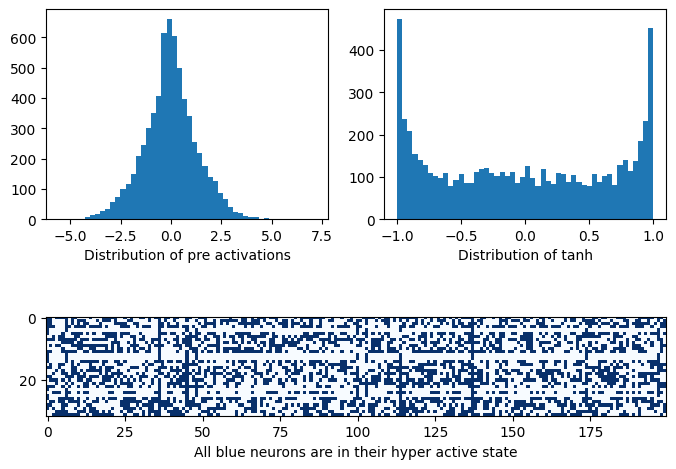

In [8]:
plt.figure(figsize=(8, 6))

ax1 = plt.subplot(221)
ax1.set_xlabel("Distribution of pre activations")
ax1.hist(hpreact.view(-1).tolist(), 50)

ax2 = plt.subplot(222)
ax2.set_xlabel("Distribution of tanh")
ax2.hist(h.view(-1).tolist(), 50)

ax3 = plt.subplot(212)
ax3.imshow(hpreact.abs() > 0.99, cmap="Blues", interpolation="nearest")
ax3.set_xlabel("All blue neurons are in their hyper active state")

plt.show();

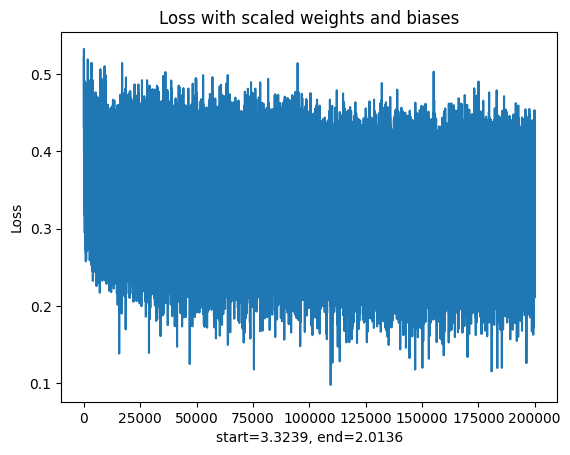

In [9]:
plt.plot(losses)
plt.title("Loss with scaled weights and biases")
plt.ylabel("Loss")
plt.xlabel(f"start={10 ** losses[0]:.4f}, end={10 ** losses[-1]:.4f}");

In [10]:
@torch.no_grad()
def split_loss(split):
    x, y = {"train": (Xtr, Ytr), "val": (Xdev, Ydev), "test": (Xte, Yte)}[split]
    # pass the training set through
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1

    # Batch Normalization
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


print(f"Last train loss {10 ** losses[-1]}")


split_loss("train")
split_loss("test")
split_loss("val")

Last train loss 2.0136201527502573
train 2.0674145221710205
test 2.1070175170898438
val 2.1056838035583496


In [11]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all [0]
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]  # (1, block_size, n_embed)
        hpreact = emb.view(1, -1) @ W1
        hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
        h = torch.tanh(hpreact)  # concatenate the vectors
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))  # decode and print the generated word

carlah.
amorie.
khi.
mri.
reity.
salaysie.
mahnen.
delynn.
jareei.
ner.
kiah.
maiivia.
leigh.
ham.
joce.
quint.
salin.
alianni.
wate.
madiaryn.
